In [ ]:
import pandas as pd
import numpy as np
import regex as re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics.pairwise import linear_kernel


from sklearn import metrics
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

import gensim
import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Connecting to google drive files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CZ4045 NATURAL LANG PROCESSING/Dataset/Cleaned/cleaned_labelled.csv')
df.head()

Original_Text  \
0  "He then went on to tell me about what the US ...   
1  Im crying, but I know you dont need my tears. ...   
2  Most successful first-world countries have alm...   
3  Look at Scandinavian countries too. Many have ...   
4  what an incredibly stale and ignorant take on ...   

                                        Cleaned_Text  \
0  he then went on to tell me about what the us w...   
1  im crying but i know you dont need my tears im...   
2  most successful firstworld countries have almo...   
3  look at scandinavian countries too many have p...   
4  what an incredibly stale and ignorant take on ...   

                                     Lemmatized_Text  \
0  went tell u like back started turn onward form...   
1  im cry know dont need tear im praying voice re...   
2  successful firstworld country almost completel...   
3  look scandinavian country many permitting requ...   
4  incredibly stale ignorant take gun violence am...   

                                        Stemmed_Text  Label  
0  went tell us like back start turn onward form ...      0  
1  im cri know dont need tear im pray voic reach ...      1  
2  success firstworld countri almost complet ban ...      1  
3  look scandinavian countri mani permit requir b...     -1  
4  incred stale ignor take gun violenc america li...      1

# Processing Subjectivity and Polarity of Labels

Logic for generating values within Polarity and Subjectivity labels:

Subjectivity is checking whether the statement is opinionated or neutral hence labels with 0 is categorized as neutral (0) and (1, -1) is categorized as opinionated (1) 

Polarity neutral and negative opinions (0, -1) is categorized as negative (0) and 1 as positive (1). 

In [ ]:
#Creating new coulmns Subjectivity and Polarity
df["Polarity"] = df['Label']
df["Subjectivity"] = df['Label']

#Generating values for Polarity and Subjectivity
df['Subjectivity'] = np.where((df['Label'] == -1), 1, df['Subjectivity'])
df['Polarity'] = np.where((df['Label'] == -1), 0, df['Polarity'])
 
#Add csv value to columns
df.to_csv('/content/drive/MyDrive/CZ4045 NATURAL LANG PROCESSING/Dataset/Cleaned/final_output.csv', index=False)
df.head()

Original_Text  \
0  "He then went on to tell me about what the US ...   
1  Im crying, but I know you dont need my tears. ...   
2  Most successful first-world countries have alm...   
3  Look at Scandinavian countries too. Many have ...   
4  what an incredibly stale and ignorant take on ...   

                                        Cleaned_Text  \
0  he then went on to tell me about what the us w...   
1  im crying but i know you dont need my tears im...   
2  most successful firstworld countries have almo...   
3  look at scandinavian countries too many have p...   
4  what an incredibly stale and ignorant take on ...   

                                     Lemmatized_Text  \
0  went tell u like back started turn onward form...   
1  im cry know dont need tear im praying voice re...   
2  successful firstworld country almost completel...   
3  look scandinavian country many permitting requ...   
4  incredibly stale ignorant take gun violence am...   

                                        Stemmed_Text  Label  Polarity  \
0  went tell us like back start turn onward form ...      0         0   
1  im cri know dont need tear im pray voic reach ...      1         1   
2  success firstworld countri almost complet ban ...      1         1   
3  look scandinavian countri mani permit requir b...     -1         0   
4  incred stale ignor take gun violenc america li...      1         1   

   Subjectivity  
0             0  
1             1  
2             1  
3             1  
4             1

In [ ]:
def evaluate(model, x_test, y_test, predict):

       # Confusion Matrix
    print("~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-\n")
    ConfusionMatrixDisplay.from_predictions(y_test, predict)
    plt.show()
    print()

        # Evaluation Metrics
    print("~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~\n")
    result = classification_report(y_test, predict, digits = 3, zero_division = 0)
    print(result)

        # 5 fold cross validation
    print("~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~\n")
    print('F1 score:         {0:0.3f}'.format(cross_val_score(model, x_test, y_test,scoring = "f1", cv = 5).mean()))
    print('Precision score:  {0:0.3f}'.format(cross_val_score(model, x_test, y_test,scoring = "precision", cv = 5).mean()))
    print('Recall score:     {0:0.3f}\n'.format(cross_val_score(model, x_test, y_test,scoring = "recall", cv = 5).mean()))
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

    return classification_report(y_test, predict, digits = 3, zero_division = 0, output_dict= True)

# Naive Bayes Classfication Models

In [ ]:
# Split into training and testing data
def naiveBayesModel(x, x_test, y, y_test, data_type):

    model = MultinomialNB()
    model.fit(x, y)

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)

    print()
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Naive Bayes Classification")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)

    return result

In [ ]:
# Split into training and testing data
def complementNaiveBayesModel(x, x_test, y, y_test, data_type):

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)

    model = ComplementNB()
    model.fit(x, y)

    print()
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Complement Naive Bayes Classification")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)

    return result

# K Nearest Neighbour Classification

In [ ]:
def KNNClassification(x, x_test, y, y_test, data_type):
    
    metric = ['euclidean', 'cosine']
    neighbors = [5,15]
    leaf_size = [30,60]
    weight = ['uniform', 'distance']
    param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
    grid_search.fit(x_test, y_test)
    grid_search.best_params_
    
    knn_model = KNeighborsClassifier(n_neighbors = grid_search.best_params_['n_neighbors'], metric= grid_search.best_params_['metric'], leaf_size = grid_search.best_params_['leaf_size'], weights = grid_search.best_params_['weights'])
    knn_model.fit(x, y)   
    '''
    knn_model = KNeighborsClassifier()
    knn_model.fit(x, y)
    '''
    print()
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: K Nearest Neighbour Classification")
    print("     Preprocessed Text Used: ", data_type)
    print("     Best Parameters       :", grid_search.best_params_)
    print()
    predict = knn_model.predict(x_test)

    result = evaluate(knn_model, x_test, y_test, predict)

    return result

# RandomForest Classifier

In [ ]:
def RandomForestClassification(x, x_test, y, y_test, data_type):
    
    rfc = RandomForestClassifier() 
    # Number of trees in random forest
    n_estimators = [10,100]
    # Number of features to consider at every split
    max_features = ['sqrt', 'log2']
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2]
    # Create the random grid
    param_grid = {
                   'n_estimators': n_estimators,
                   'max_features': max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                }


    grid_search = GridSearchCV(rfc, param_grid, cv= 5)
    grid_search.fit(x_test, y_test)
    grid_search.best_params_
    
    randomforest_model = RandomForestClassifier(
                                                max_features = grid_search.best_params_['max_features'],
                                                n_estimators = grid_search.best_params_['n_estimators'],
                                                min_samples_split = grid_search.best_params_['min_samples_split'],
                                                min_samples_leaf = grid_search.best_params_['min_samples_leaf'])
    randomforest_model.fit(x, y)
    
    #randomforest_model = RandomForestClassifier()
    #randomforest_model.fit(x, y)
    print()
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Random Forest Classification")
    print("     Preprocessed Text Used: ", data_type)
    print("     Best Parameters       :", grid_search.best_params_)
    print()
    predict = randomforest_model.predict(x_test)

    result = evaluate(randomforest_model, x_test, y_test, predict)

    return result

#Converting Text using Doc2Vec

Learn paragraph and document embeddings via the distributed memory and distributed bag of words models

In [ ]:
def convert_doc2vec(df, col):
  def tagged_document(list_of_list_of_words):
      for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
  data_training = list(tagged_document(df[col]))
  model = gensim.models.doc2vec.Doc2Vec(data_training, vector_size=40, window=10, min_count=2, workers=4)

  data = df[col].apply(model.infer_vector)
  df2 = pd.DataFrame(data.tolist(), columns = [str(i) for i in range(1, 41)])
  df2[["Label", "Polarity", "Subjectivity"]] = df[["Label", "Polarity", "Subjectivity"]].copy()

  return df2

In [ ]:
cleaned_text_df = convert_doc2vec(df, "Cleaned_Text")
cleaned_text_df.head()

1         2         3         4         5         6         7  \
0 -0.048997  0.105739 -0.141202  0.036758  0.037749  0.123996 -0.038749   
1 -0.028018  0.008397 -0.014493  0.053215  0.025924 -0.032991 -0.015404   
2 -0.029396 -0.031025 -0.036597  0.097483  0.012786  0.008243  0.012573   
3 -0.019981  0.078238 -0.042388  0.075213 -0.082340 -0.040616  0.046461   
4 -0.038101 -0.169314 -0.051853  0.087748  0.036480  0.026271  0.076832   

          8         9        10  ...        34        35        36        37  \
0 -0.067653  0.038579 -0.058146  ...  0.047921 -0.087615 -0.109729 -0.069285   
1  0.036813 -0.035666  0.043958  ... -0.002605 -0.067282  0.048291 -0.016299   
2  0.039532  0.025323  0.041627  ... -0.034250 -0.080856  0.035923 -0.024854   
3 -0.041919 -0.035837 -0.094058  ... -0.078478  0.023076  0.002946  0.025758   
4  0.020714 -0.099243  0.107900  ...  0.056470 -0.110972  0.052678 -0.021547   

         38        39        40  Label  Polarity  Subjectivity  
0 -0.253983  0.144753  0.031677      0         0             0  
1 -0.079346 -0.023625  0.027634      1         1             1  
2 -0.153349 -0.004200  0.028559      1         1             1  
3 -0.135875 -0.124180 -0.023079     -1         0             1  
4 -0.058578 -0.039981 -0.015072      1         1             1  

[5 rows x 43 columns]

#Training the Classification Model for Doc2Vec

Takes in the output vector from the doc2vec model and uses it as inputs for a regular classification model. Below, we will use logistic regression, decision tree, random forest, and SVM to attempt to classify each sample.


In [ ]:
# Logistic Regression
def logReg(x, x_test, y, y_test, data_type):

    model = LogisticRegression()
    model.fit(x, y)

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)
    
    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Logistic Regression on Doc2Vec")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)

    return result

In [ ]:
# Decision Tree
def decTree(x, x_test, y, y_test, data_type):

    model = tree.DecisionTreeClassifier()
    model.fit(x, y)

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)

    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Decision Tree on Doc2Vec")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)
    
    return result

In [ ]:
# Random Forest
def randForest(x, x_test, y, y_test, data_type):

    model = RandomForestClassifier()
    model.fit(x, y)

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)

    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Random Forest on Doc2Vec")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)
    
    return result

In [ ]:
# Support Vector Machine Classifier
def SVC(x, x_test, y, y_test, data_type):

    model = svm.SVC()
    model.fit(x, y)

    # print(x.shape, y.shape)
    # print(x_test.shape, y_test.shape)

    print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
    print("     Model: Support Vector Classifier on Doc2Vec")
    print("     Preprocessed Text Used: ", data_type)
    print()
    predict = model.predict(x_test)

    result = evaluate(model, x_test, y_test, predict)
    
    return result

# Bar Chart Plotting

In [ ]:
def plotbar(NBresult, CNBresult, KNNresult, RFresult):
  N = 3
  results = {'Naive Bayes':NBresult, 'Complement Naive Bayes':CNBresult, 'KNN':KNNresult, 'Random Forest': RFresult}
  ind = np.arange(N) 
  width = 0.1
  f = []
  clr = ['r','c','m','y','g']
  i=0

  for a,b in results.items():
    tmp = [b['weighted avg']['precision'], b['weighted avg']['recall'], b['weighted avg']['f1-score']]
    f.append(plt.bar(ind+width*i, tmp, width, color = clr[i]))
    i+=1

  plt.xlabel("Metrics")
  plt.ylabel('Score')
  plt.title("Over all weighted scores")
  plt.xticks(ind+width,['Precision', 'Recall', 'F1-score'])
  plt.legend( tuple(f), tuple(results.keys()), loc='lower center', ncol=7)
  plt.show()

# Subjectivity Classification

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             Count Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



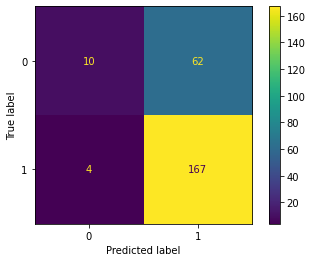


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.714     0.139     0.233        72
           1      0.729     0.977     0.835       171

    accuracy                          0.728       243
   macro avg      0.722     0.558     0.534       243
weighted avg      0.725     0.728     0.656       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 3.7408 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



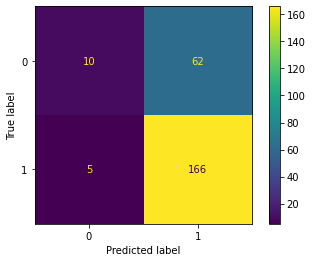


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.667     0.139     0.230        72
           1      0.728     0.971     0.832       171

    accuracy                          0.724       243
   macro avg      0.697     0.555     0.531       243
weighted avg      0.710     0.724     0.654       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 3.7842 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~

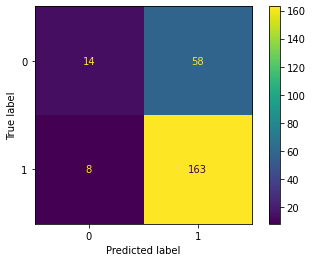


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.636     0.194     0.298        72
           1      0.738     0.953     0.832       171

    accuracy                          0.728       243
   macro avg      0.687     0.574     0.565       243
weighted avg      0.708     0.728     0.673       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.825
Precision score:  0.728
Recall score:     0.953

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 17.3092 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matr

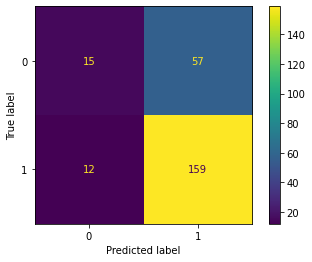


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.556     0.208     0.303        72
           1      0.736     0.930     0.822       171

    accuracy                          0.716       243
   macro avg      0.646     0.569     0.562       243
weighted avg      0.683     0.716     0.668       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.822
Precision score:  0.707
Recall score:     0.994

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 42.4573 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



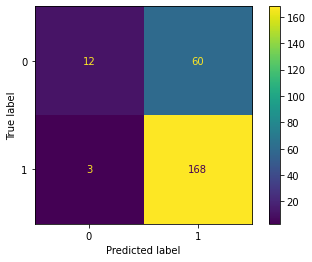


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.800     0.167     0.276        72
           1      0.737     0.982     0.842       171

    accuracy                          0.741       243
   macro avg      0.768     0.575     0.559       243
weighted avg      0.756     0.741     0.674       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 5.1456 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



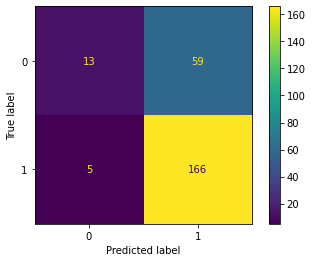


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.722     0.181     0.289        72
           1      0.738     0.971     0.838       171

    accuracy                          0.737       243
   macro avg      0.730     0.576     0.564       243
weighted avg      0.733     0.737     0.676       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.828
Precision score:  0.707
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 5.8823 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix

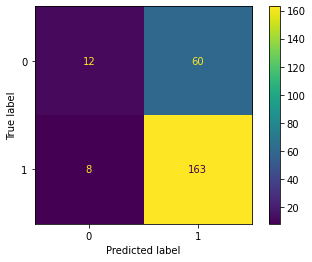


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.600     0.167     0.261        72
           1      0.731     0.953     0.827       171

    accuracy                          0.720       243
   macro avg      0.665     0.560     0.544       243
weighted avg      0.692     0.720     0.660       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.825
Precision score:  0.728
Recall score:     0.953

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 20.0491 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion 

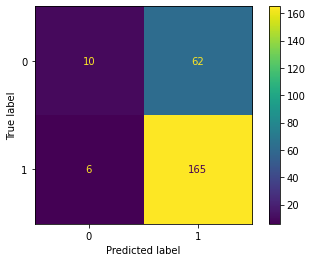


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.625     0.139     0.227        72
           1      0.727     0.965     0.829       171

    accuracy                          0.720       243
   macro avg      0.676     0.552     0.528       243
weighted avg      0.697     0.720     0.651       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.823
Precision score:  0.703
Recall score:     0.988

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 96.4325 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             TF-IDF Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Tex

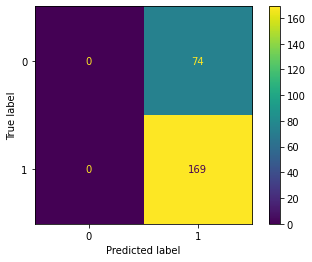


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.695     1.000     0.820       169

    accuracy                          0.695       243
   macro avg      0.348     0.500     0.410       243
weighted avg      0.484     0.695     0.571       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 0.2061 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



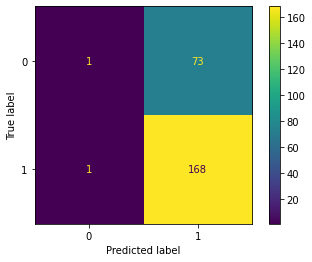


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.014     0.026        74
           1      0.697     0.994     0.820       169

    accuracy                          0.695       243
   macro avg      0.599     0.504     0.423       243
weighted avg      0.637     0.695     0.578       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 0.2054 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix

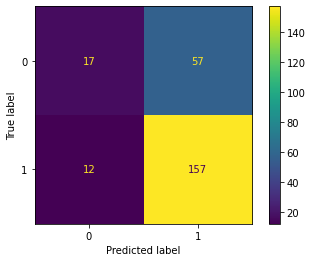


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.586     0.230     0.330        74
           1      0.734     0.929     0.820       169

    accuracy                          0.716       243
   macro avg      0.660     0.579     0.575       243
weighted avg      0.689     0.716     0.671       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.815
Precision score:  0.693
Recall score:     0.988

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 0.4495 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matri

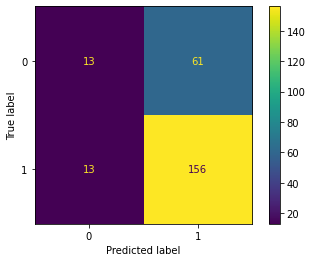


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.176     0.260        74
           1      0.719     0.923     0.808       169

    accuracy                          0.695       243
   macro avg      0.609     0.549     0.534       243
weighted avg      0.652     0.695     0.641       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.809
Precision score:  0.692
Recall score:     0.964

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 8.2068 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



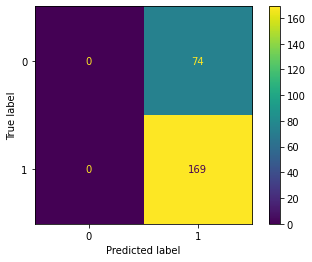


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.695     1.000     0.820       169

    accuracy                          0.695       243
   macro avg      0.348     0.500     0.410       243
weighted avg      0.484     0.695     0.571       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 0.1999 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



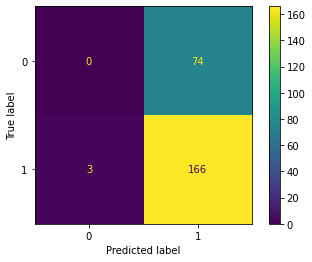


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.692     0.982     0.812       169

    accuracy                          0.683       243
   macro avg      0.346     0.491     0.406       243
weighted avg      0.481     0.683     0.565       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.822
Precision score:  0.698
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 0.2029 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Mat

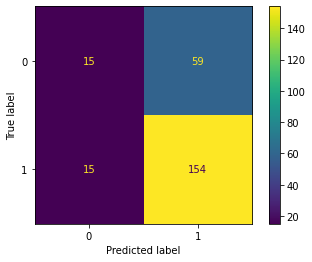


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.203     0.288        74
           1      0.723     0.911     0.806       169

    accuracy                          0.695       243
   macro avg      0.612     0.557     0.547       243
weighted avg      0.655     0.695     0.649       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.808
Precision score:  0.690
Recall score:     0.976

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 0.5435 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Ma

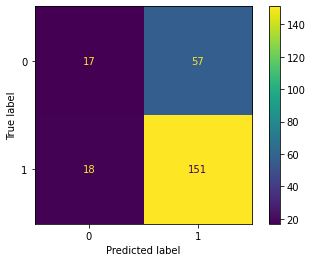


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.486     0.230     0.312        74
           1      0.726     0.893     0.801       169

    accuracy                          0.691       243
   macro avg      0.606     0.562     0.556       243
weighted avg      0.653     0.691     0.652       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.803


Precision score:  0.702
Recall score:     0.976

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 8.1481 seconds


~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             Doc2Vec Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Logistic Regression on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



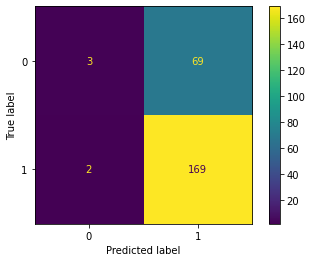


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.600     0.042     0.078        72
           1      0.710     0.988     0.826       171

    accuracy                          0.708       243
   macro avg      0.655     0.515     0.452       243
weighted avg      0.677     0.708     0.605       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Logistic Regression on Doc2Vec in 0.4422 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Decision Tree on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



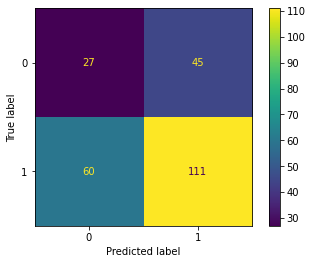


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.310     0.375     0.340        72
           1      0.712     0.649     0.679       171

    accuracy                          0.568       243
   macro avg      0.511     0.512     0.509       243
weighted avg      0.593     0.568     0.578       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.709
Precision score:  0.717
Recall score:     0.714

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Decision Tree on Doc2Vec in 0.3064 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



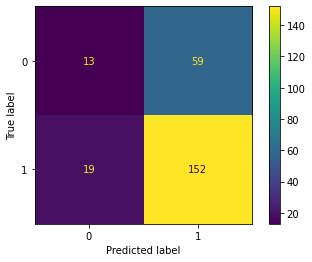


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.406     0.181     0.250        72
           1      0.720     0.889     0.796       171

    accuracy                          0.679       243
   macro avg      0.563     0.535     0.523       243
weighted avg      0.627     0.679     0.634       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.808
Precision score:  0.707
Recall score:     0.948

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest on Doc2Vec in 3.1021 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Support Vector Classifier on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



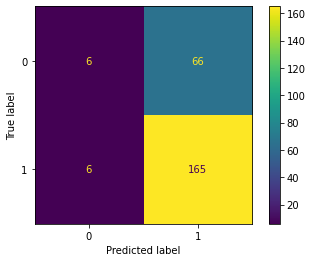


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.083     0.143        72
           1      0.714     0.965     0.821       171

    accuracy                          0.704       243
   macro avg      0.607     0.524     0.482       243
weighted avg      0.651     0.704     0.620       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for SVC on Doc2Vec in 0.3281 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Logistic Regression on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



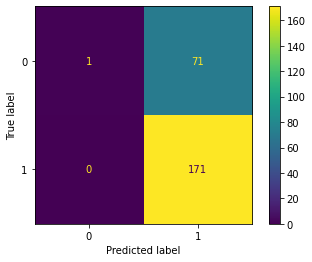


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      1.000     0.014     0.027        72
           1      0.707     1.000     0.828       171

    accuracy                          0.708       243
   macro avg      0.853     0.507     0.428       243
weighted avg      0.794     0.708     0.591       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Logistic Regression on Doc2Vec in 0.3154 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Decision Tree on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



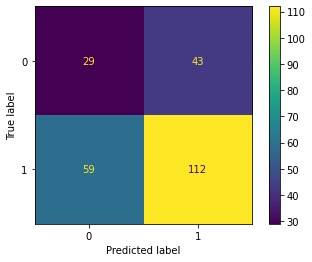


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.330     0.403     0.363        72
           1      0.723     0.655     0.687       171

    accuracy                          0.580       243
   macro avg      0.526     0.529     0.525       243
weighted avg      0.606     0.580     0.591       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.677
Precision score:  0.684
Recall score:     0.633

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Decision Tree on Doc2Vec in 0.2887 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



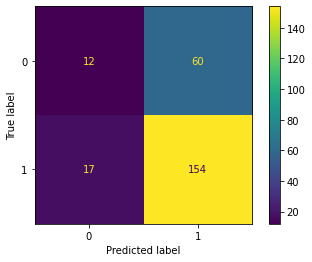


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.414     0.167     0.238        72
           1      0.720     0.901     0.800       171

    accuracy                          0.683       243
   macro avg      0.567     0.534     0.519       243
weighted avg      0.629     0.683     0.633       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.803
Precision score:  0.709
Recall score:     0.936

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest on Doc2Vec in 3.1104 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Support Vector Classifier on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



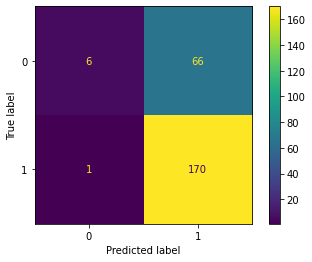


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.857     0.083     0.152        72
           1      0.720     0.994     0.835       171

    accuracy                          0.724       243
   macro avg      0.789     0.539     0.494       243
weighted avg      0.761     0.724     0.633       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.826
Precision score:  0.704
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for SVC on Doc2Vec in 0.3319 seconds


In [ ]:
processed_data = ['Stemmed_Text', 'Lemmatized_Text'] 

#Count Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             Count Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

for data in processed_data:
  x, x_test, y, y_test = train_test_split(df[data], df['Subjectivity'], test_size=0.2, random_state=28)

  count_vec = CountVectorizer(ngram_range=(1,2))
  x = count_vec.fit_transform(x).toarray()
  x_test = count_vec.transform(x_test).toarray()

  tic = time.perf_counter()
  NBresult = naiveBayesModel(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for Naive Bayes in {toc - tic:0.4f} seconds")
  
  tic = time.perf_counter()
  CNBresult = complementNaiveBayesModel(x, x_test, y, y_test, data)  
  toc = time.perf_counter()
  print(f"Text Classified for Complement Naive Bayes in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  KNNresult = KNNClassification(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for K Nearest Neighbour in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  RFresult = RandomForestClassification(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for Random Forest in {toc - tic:0.4f} seconds")

  #plotbar(NBresult, CNBresult, KNNresult, RFresult)

#TF-IDF Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             TF-IDF Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

for data in processed_data:
    x, x_test, y, y_test = train_test_split(df[data], df['Subjectivity'], test_size = 0.2, random_state = 24)
    
    vectorizer = TfidfVectorizer(use_idf = True, sublinear_tf = True)
    x = vectorizer.fit_transform(x)
    x_test = vectorizer.transform(x_test)

    tic = time.perf_counter()
    NBresult = naiveBayesModel(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for Naive Bayes in {toc - tic:0.4f} seconds")
    
    tic = time.perf_counter()
    CNBresult = complementNaiveBayesModel(x, x_test, y, y_test, data)  
    toc = time.perf_counter()
    print(f"Text Classified for Complement Naive Bayes in {toc - tic:0.4f} seconds")

    tic = time.perf_counter()
    KNNresult = KNNClassification(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for K Nearest Neighbour in {toc - tic:0.4f} seconds")

    tic = time.perf_counter()
    RFresult = RandomForestClassification(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for Random Forest in {toc - tic:0.4f} seconds")
    

processed_df = [convert_doc2vec(df, text) for text in processed_data]

#Doc2Vec Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             Doc2Vec Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

for i in range(len(processed_data)):
  x, x_test, y, y_test = train_test_split(processed_df[i].iloc[: , :40], processed_df[i]['Subjectivity'], test_size=0.2, random_state=28)

  tic = time.perf_counter()
  LogRegResult = logReg(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Logistic Regression on Doc2Vec in {toc - tic:0.4f} seconds")
  
  tic = time.perf_counter()
  DecTreeResult = decTree(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Decision Tree on Doc2Vec in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  RFResult = randForest(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Random Forest on Doc2Vec in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  SVCResult = SVC(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for SVC on Doc2Vec in {toc - tic:0.4f} seconds")


# Polarity Detection

In [ ]:
df_polarity = df.loc[df["Subjectivity"] == 1]
df_polarity.head()

Original_Text  \
1  Im crying, but I know you dont need my tears. ...   
2  Most successful first-world countries have alm...   
3  Look at Scandinavian countries too. Many have ...   
4  what an incredibly stale and ignorant take on ...   
5  He literally wrote (right after Uvalde shootin...   

                                        Cleaned_Text  \
1  im crying but i know you dont need my tears im...   
2  most successful firstworld countries have almo...   
3  look at scandinavian countries too many have p...   
4  what an incredibly stale and ignorant take on ...   
5  he literally wrote right after uvalde shooting...   

                                     Lemmatized_Text  \
1  im cry know dont need tear im praying voice re...   
2  successful firstworld country almost completel...   
3  look scandinavian country many permitting requ...   
4  incredibly stale ignorant take gun violence am...   
5  literally wrote right uvalde shooting every vi...   

                                        Stemmed_Text  Label  Polarity  \
1  im cri know dont need tear im pray voic reach ...      1         1   
2  success firstworld countri almost complet ban ...      1         1   
3  look scandinavian countri mani permit requir b...     -1         0   
4  incred stale ignor take gun violenc america li...      1         1   
5  liter wrote right uvald shoot everi violent de...      1         1   

   Subjectivity  
1             1  
2             1  
3             1  
4             1  
5             1

In [ ]:
polarity_df = [df[df["Subjectivity"] == 1].copy() for df in processed_df]
polarity_df[0].head()

1         2         3         4         5         6         7  \
1 -0.025997 -0.002230 -0.013812  0.067990 -0.007998 -0.005684 -0.002623   
2 -0.003944 -0.002825 -0.002304  0.043992 -0.035623 -0.019833  0.009796   
3 -0.000841  0.069725  0.004352  0.051793  0.015497 -0.038411  0.004152   
4  0.007856  0.054637 -0.033218  0.153191 -0.011590  0.001142  0.055043   
5  0.052851  0.092627 -0.001823  0.081777  0.047533 -0.045671  0.016064   

          8         9        10  ...        34        35        36        37  \
1  0.080436  0.062948  0.016453  ... -0.013127 -0.041328  0.059960  0.010284   
2  0.020038  0.051051  0.052262  ... -0.022038 -0.018294  0.036587  0.018162   
3 -0.012723  0.075228  0.007581  ... -0.059016 -0.009621  0.030631  0.024406   
4 -0.034602  0.066010  0.098448  ... -0.000710  0.000514 -0.106126  0.072202   
5  0.044986  0.076122 -0.007248  ... -0.014470 -0.024993  0.068533  0.039371   

         38        39        40  Label  Polarity  Subjectivity  
1 -0.040704 -0.018598 -0.004229      1         1             1  
2 -0.041169 -0.026086  0.011295      1         1             1  
3 -0.054827 -0.027487  0.126221     -1         0             1  
4  0.070241 -0.050113 -0.110618      1         1             1  
5  0.021620 -0.067837  0.067816      1         1             1  

[5 rows x 43 columns]

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             Count Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



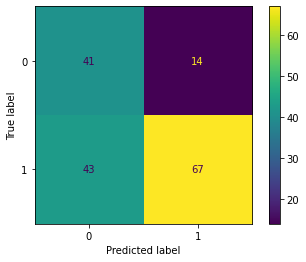


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.488     0.745     0.590        55
           1      0.827     0.609     0.702       110

    accuracy                          0.655       165
   macro avg      0.658     0.677     0.646       165
weighted avg      0.714     0.655     0.664       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.790
Precision score:  0.689
Recall score:     0.927

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 2.4365 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



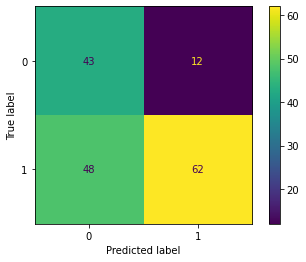


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.473     0.782     0.589        55
           1      0.838     0.564     0.674       110

    accuracy                          0.636       165
   macro avg      0.655     0.673     0.631       165
weighted avg      0.716     0.636     0.646       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.779
Precision score:  0.688
Recall score:     0.900

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 2.4297 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix 

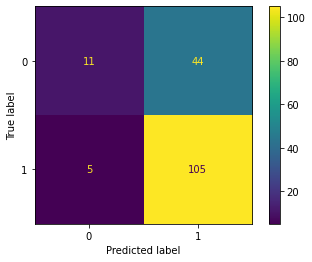


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.688     0.200     0.310        55
           1      0.705     0.955     0.811       110

    accuracy                          0.703       165
   macro avg      0.696     0.577     0.560       165
weighted avg      0.699     0.703     0.644       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.812
Precision score:  0.712
Recall score:     0.945

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 6.4374 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matri

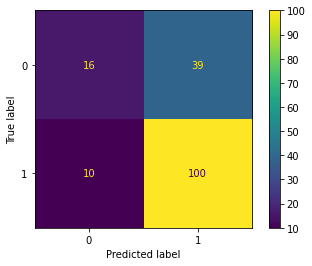


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.615     0.291     0.395        55
           1      0.719     0.909     0.803       110

    accuracy                          0.703       165
   macro avg      0.667     0.600     0.599       165
weighted avg      0.685     0.703     0.667       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.802
Precision score:  0.682
Recall score:     0.936

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 14.8038 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



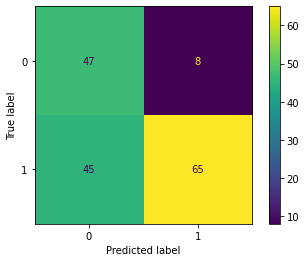


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.511     0.855     0.639        55
           1      0.890     0.591     0.710       110

    accuracy                          0.679       165
   macro avg      0.701     0.723     0.675       165
weighted avg      0.764     0.679     0.687       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.806
Precision score:  0.714
Recall score:     0.927

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 1.6629 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



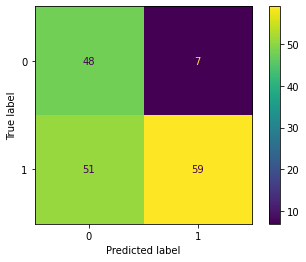


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.485     0.873     0.623        55
           1      0.894     0.536     0.670       110

    accuracy                          0.648       165
   macro avg      0.689     0.705     0.647       165
weighted avg      0.758     0.648     0.655       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.802
Precision score:  0.712
Recall score:     0.918

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 1.6854 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matr

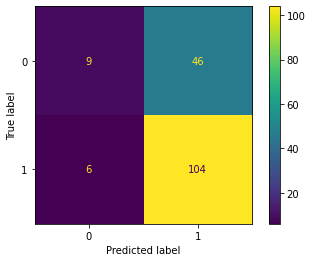


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.600     0.164     0.257        55
           1      0.693     0.945     0.800       110

    accuracy                          0.685       165
   macro avg      0.647     0.555     0.529       165
weighted avg      0.662     0.685     0.619       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.817
Precision score:  0.715
Recall score:     0.955

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 6.3089 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Ma

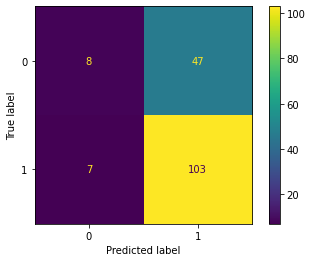


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.533     0.145     0.229        55
           1      0.687     0.936     0.792       110

    accuracy                          0.673       165
   macro avg      0.610     0.541     0.510       165
weighted avg      0.636     0.673     0.604       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.796
Precision score:  0.687
Recall score:     0.955

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 16.7688 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             TF-IDF Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Tex

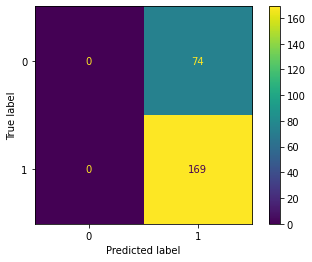


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.695     1.000     0.820       169

    accuracy                          0.695       243
   macro avg      0.348     0.500     0.410       243
weighted avg      0.484     0.695     0.571       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 0.1922 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



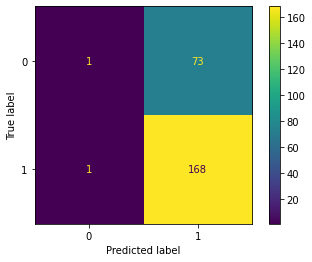


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.014     0.026        74
           1      0.697     0.994     0.820       169

    accuracy                          0.695       243
   macro avg      0.599     0.504     0.423       243
weighted avg      0.637     0.695     0.578       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 0.2371 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix

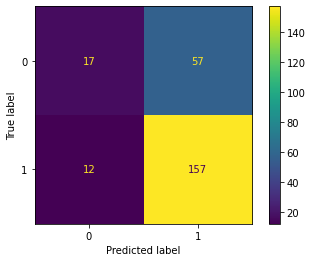


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.586     0.230     0.330        74
           1      0.734     0.929     0.820       169

    accuracy                          0.716       243
   macro avg      0.660     0.579     0.575       243
weighted avg      0.689     0.716     0.671       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.815
Precision score:  0.693
Recall score:     0.988

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 0.4335 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Stemmed_Text
     Best Parameters       : {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matri

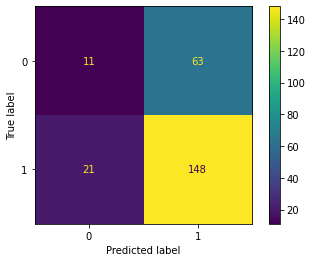


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.344     0.149     0.208        74
           1      0.701     0.876     0.779       169

    accuracy                          0.654       243
   macro avg      0.523     0.512     0.493       243
weighted avg      0.593     0.654     0.605       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.812
Precision score:  0.700
Recall score:     0.941

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 8.0508 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



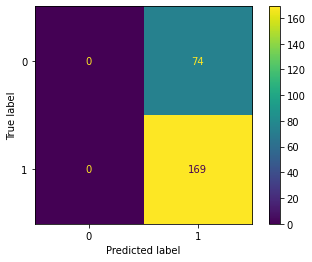


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.695     1.000     0.820       169

    accuracy                          0.695       243
   macro avg      0.348     0.500     0.410       243
weighted avg      0.484     0.695     0.571       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Naive Bayes in 0.2014 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Complement Naive Bayes Classification
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



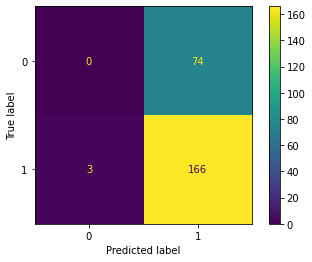


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.692     0.982     0.812       169

    accuracy                          0.683       243
   macro avg      0.346     0.491     0.406       243
weighted avg      0.481     0.683     0.565       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.822
Precision score:  0.698
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Complement Naive Bayes in 0.2065 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: K Nearest Neighbour Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Mat

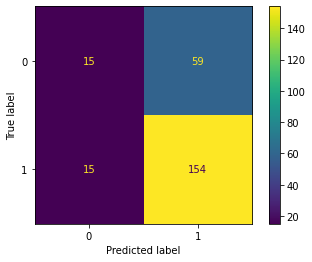


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.500     0.203     0.288        74
           1      0.723     0.911     0.806       169

    accuracy                          0.695       243
   macro avg      0.612     0.557     0.547       243
weighted avg      0.655     0.695     0.649       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.808
Precision score:  0.690
Recall score:     0.976

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for K Nearest Neighbour in 0.5439 seconds

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest Classification
     Preprocessed Text Used:  Lemmatized_Text
     Best Parameters       : {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion M

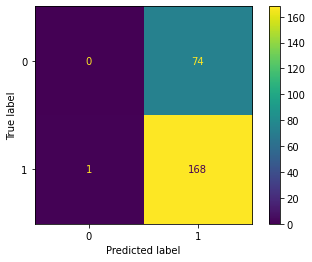


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        74
           1      0.694     0.994     0.818       169

    accuracy                          0.691       243
   macro avg      0.347     0.497     0.409       243
weighted avg      0.483     0.691     0.569       243

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.820
Precision score:  0.695
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest in 11.4044 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

                             Doc2Vec Vectorizer
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Logistic Regression on Doc2Vec
     Preprocessed

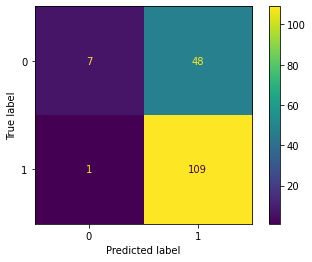


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.875     0.127     0.222        55
           1      0.694     0.991     0.816       110

    accuracy                          0.703       165
   macro avg      0.785     0.559     0.519       165
weighted avg      0.755     0.703     0.618       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.800
Precision score:  0.667
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Logistic Regression on Doc2Vec in 0.3071 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Decision Tree on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



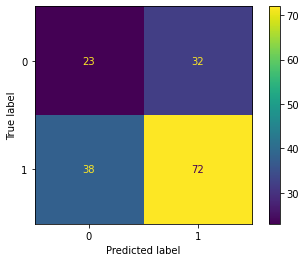


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.377     0.418     0.397        55
           1      0.692     0.655     0.673       110

    accuracy                          0.576       165
   macro avg      0.535     0.536     0.535       165
weighted avg      0.587     0.576     0.581       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.695
Precision score:  0.766
Recall score:     0.645

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Decision Tree on Doc2Vec in 0.2679 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



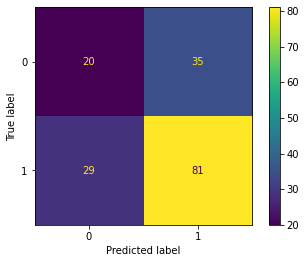


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.408     0.364     0.385        55
           1      0.698     0.736     0.717       110

    accuracy                          0.612       165
   macro avg      0.553     0.550     0.551       165
weighted avg      0.602     0.612     0.606       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.759
Precision score:  0.696
Recall score:     0.836

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest on Doc2Vec in 2.6912 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Support Vector Classifier on Doc2Vec
     Preprocessed Text Used:  Stemmed_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



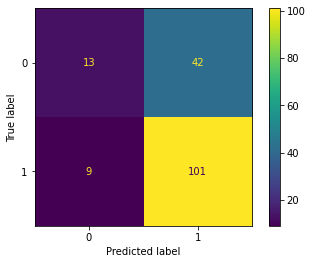


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.591     0.236     0.338        55
           1      0.706     0.918     0.798       110

    accuracy                          0.691       165
   macro avg      0.649     0.577     0.568       165
weighted avg      0.668     0.691     0.645       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.800
Precision score:  0.684
Recall score:     0.964

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for SVC on Doc2Vec in 0.2571 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Logistic Regression on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



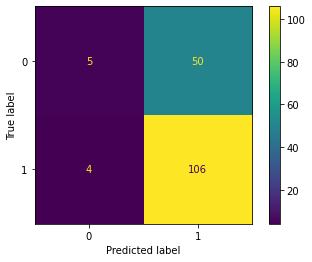


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.556     0.091     0.156        55
           1      0.679     0.964     0.797       110

    accuracy                          0.673       165
   macro avg      0.618     0.527     0.477       165
weighted avg      0.638     0.673     0.583       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.800
Precision score:  0.667
Recall score:     1.000

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Logistic Regression on Doc2Vec in 0.2987 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Decision Tree on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



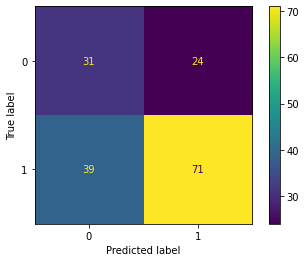


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.443     0.564     0.496        55
           1      0.747     0.645     0.693       110

    accuracy                          0.618       165
   macro avg      0.595     0.605     0.594       165
weighted avg      0.646     0.618     0.627       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.725
Precision score:  0.653
Recall score:     0.636

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Decision Tree on Doc2Vec in 0.2689 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Random Forest on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



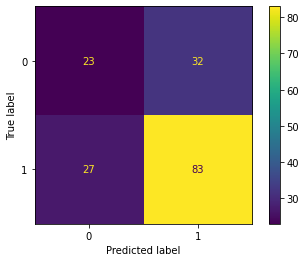


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.460     0.418     0.438        55
           1      0.722     0.755     0.738       110

    accuracy                          0.642       165
   macro avg      0.591     0.586     0.588       165
weighted avg      0.634     0.642     0.638       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.748
Precision score:  0.694
Recall score:     0.855

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for Random Forest on Doc2Vec in 2.7201 seconds
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

     Model: Support Vector Classifier on Doc2Vec
     Preprocessed Text Used:  Lemmatized_Text

~-~-~-~-~-~-~-~-~-~-~-~-~- Confusion Matrix -~-~-~-~-~-~-~-~-~-~-~-~-~-



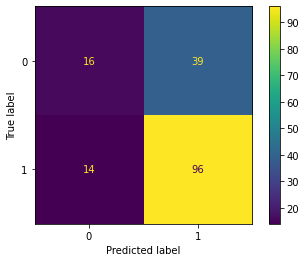


~-~-~-~-~-~-~-~-~-~-~-~- Classification Report -~-~-~-~-~-~-~-~-~-~-~-~

              precision    recall  f1-score   support

           0      0.533     0.291     0.376        55
           1      0.711     0.873     0.784       110

    accuracy                          0.679       165
   macro avg      0.622     0.582     0.580       165
weighted avg      0.652     0.679     0.648       165

~-~-~-~-~-~-~-~-~-~-~-~- 5 fold Cross Validation -~-~-~-~-~-~-~-~-~-~-~

F1 score:         0.804
Precision score:  0.677
Recall score:     0.991

~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~

Text Classified for SVC on Doc2Vec in 0.2763 seconds


In [ ]:
#Count Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             Count Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

for data in processed_data:
  x, x_test, y, y_test = train_test_split(df_polarity[data], df_polarity['Polarity'], test_size=0.2, random_state=28)

  count_vec = CountVectorizer(ngram_range=(1,2))
  x = count_vec.fit_transform(x).toarray()
  x_test = count_vec.transform(x_test).toarray()

  tic = time.perf_counter()
  NBresult = naiveBayesModel(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for Naive Bayes in {toc - tic:0.4f} seconds")
  
  tic = time.perf_counter()
  CNBresult = complementNaiveBayesModel(x, x_test, y, y_test, data)  
  toc = time.perf_counter()
  print(f"Text Classified for Complement Naive Bayes in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  KNNresult = KNNClassification(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for K Nearest Neighbour in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  RFresult = RandomForestClassification(x, x_test, y, y_test, data)
  toc = time.perf_counter()
  print(f"Text Classified for Random Forest in {toc - tic:0.4f} seconds")

  #plotbar(NBresult, CNBresult, RFresult)

#TF-IDF Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             TF-IDF Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")

for data in processed_data:
    x, x_test, y, y_test = train_test_split(df[data], df['Subjectivity'], test_size = 0.2, random_state = 24)
    
    vectorizer = TfidfVectorizer(use_idf = True, sublinear_tf = True)
    x = vectorizer.fit_transform(x)
    x_test = vectorizer.transform(x_test)

    tic = time.perf_counter()
    NBresult = naiveBayesModel(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for Naive Bayes in {toc - tic:0.4f} seconds")
    
    tic = time.perf_counter()
    CNBresult = complementNaiveBayesModel(x, x_test, y, y_test, data)  
    toc = time.perf_counter()
    print(f"Text Classified for Complement Naive Bayes in {toc - tic:0.4f} seconds")

    tic = time.perf_counter()
    KNNresult = KNNClassification(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for K Nearest Neighbour in {toc - tic:0.4f} seconds")

    tic = time.perf_counter()
    RFresult = RandomForestClassification(x, x_test, y, y_test, data)
    toc = time.perf_counter()
    print(f"Text Classified for Random Forest in {toc - tic:0.4f} seconds")

#Doc2Vec Vectorizer
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
print("                             Doc2Vec Vectorizer")
print("~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~\n")
for i in range(len(processed_data)):
  x, x_test, y, y_test = train_test_split(polarity_df[i].iloc[: , :40], polarity_df[i]['Polarity'], test_size=0.2, random_state=28)

  tic = time.perf_counter()
  LogRegResult = logReg(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Logistic Regression on Doc2Vec in {toc - tic:0.4f} seconds")
  
  tic = time.perf_counter()
  DecTreeResult = decTree(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Decision Tree on Doc2Vec in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  RFResult = randForest(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for Random Forest on Doc2Vec in {toc - tic:0.4f} seconds")

  tic = time.perf_counter()
  SVCResult = SVC(x, x_test, y, y_test, processed_data[i])
  toc = time.perf_counter()
  print(f"Text Classified for SVC on Doc2Vec in {toc - tic:0.4f} seconds")